In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb


In [168]:
# Load datasets
train_url = "https://raw.githubusercontent.com/ZakyAlFatih/gdgoc_ML/refs/heads/main/gdgoc-telu-ml-challenge/train.csv"
test_url = "https://raw.githubusercontent.com/ZakyAlFatih/gdgoc_ML/refs/heads/main/gdgoc-telu-ml-challenge/test.csv"
submission_url = "https://raw.githubusercontent.com/ZakyAlFatih/gdgoc_ML/refs/heads/main/gdgoc-telu-ml-challenge/sample_submission.csv"

train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)
submission = pd.read_csv(submission_url)

EDA

In [169]:
train_data.head()

,ID,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned,Exited
0,1,Martin,727.0,Spain,Male,38.0,2,62276.99,1,Yes,Yes,59280.79,No,4,DIAMOND,757,0
1,2,Chinweuba,529.0,France,Female,29.0,8,0.00,2,Yes,NaN,19842.11,No,3,SILVER,476,0
2,3,Clapp,589.0,France,Female,50.0,4,0.00,2,No,Yes,182076.97,No,4,PLATINUM,441,0
3,4,Boni,515.0,France,Male,40.0,0,109542.29,1,Yes,Yes,166370.81,No,5,GOLD,312,0
4,5,Jamieson,528.0,Spain,Male,43.0,7,97473.87,2,Yes,Yes,159823.16,No,3,PLATINUM,654,0


In [170]:
test_data.head()

,ID,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned
0,2001,Ugonna,693,Germany,Male,44,5,124601.58,2,Yes,Yes,46998.13,Yes,2,SILVER,408
1,2002,Nebeolisa,607,Germany,Male,29,7,102609.00,1,Yes,No,163257.44,No,5,DIAMOND,800
2,2003,Tsai,689,Spain,Male,73,1,108555.07,1,No,Yes,167969.15,No,1,PLATINUM,623
3,2004,Downie,660,France,Female,38,5,110570.78,2,Yes,No,195906.59,No,1,SILVER,472
4,2005,Morehead,503,France,Male,38,1,0.00,2,Yes,Yes,95153.24,No,2,DIAMOND,433


In [171]:
numerical_cols = [var for var in train_data.columns if train_data[var].dtype != 'object'] # get the numerical columns
categorical_cols = [var for var in train_data.columns if train_data[var].dtype == 'object'] # get the categorical columns

print('Numerical columns:')
print(numerical_cols)

Numerical columns:
['ID', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Point Earned', 'Exited']


In [172]:
print('Categorical columns:')
print(categorical_cols)

Categorical columns:
['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Complain', 'Card Type']


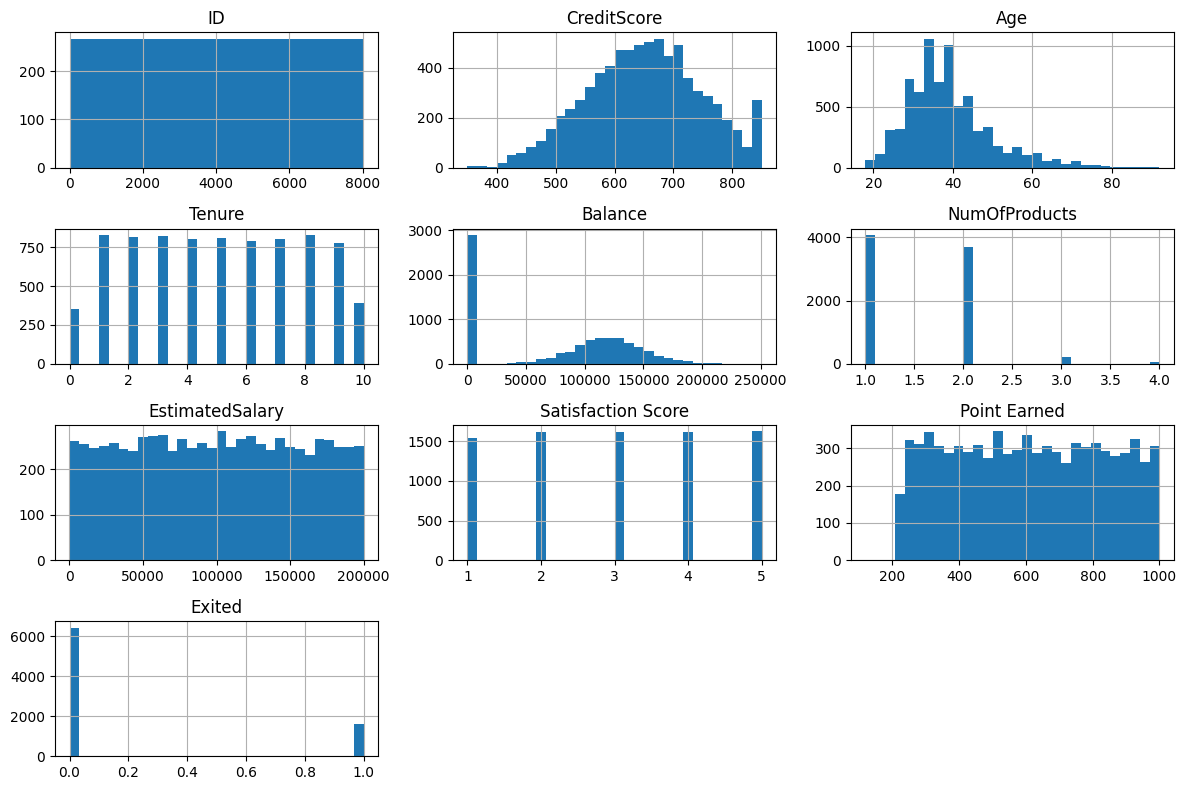

In [173]:
train_data[numerical_cols].hist(bins=30, figsize=(12,8));
plt.tight_layout()
plt.show()

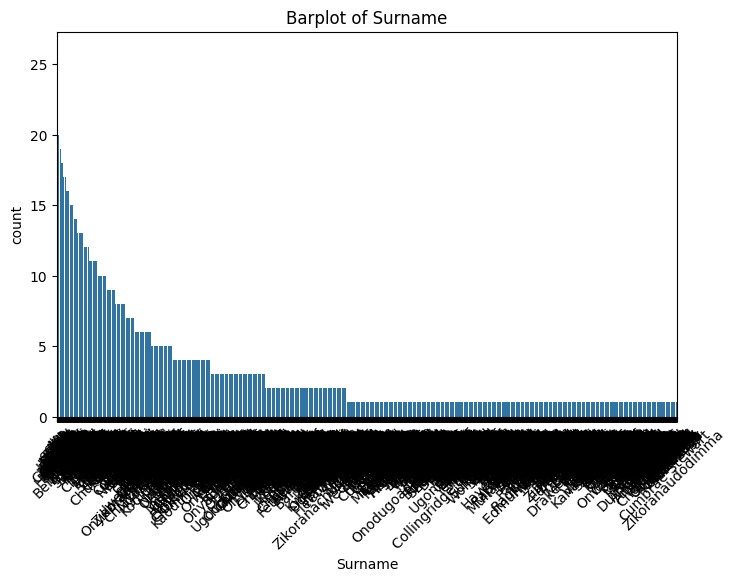

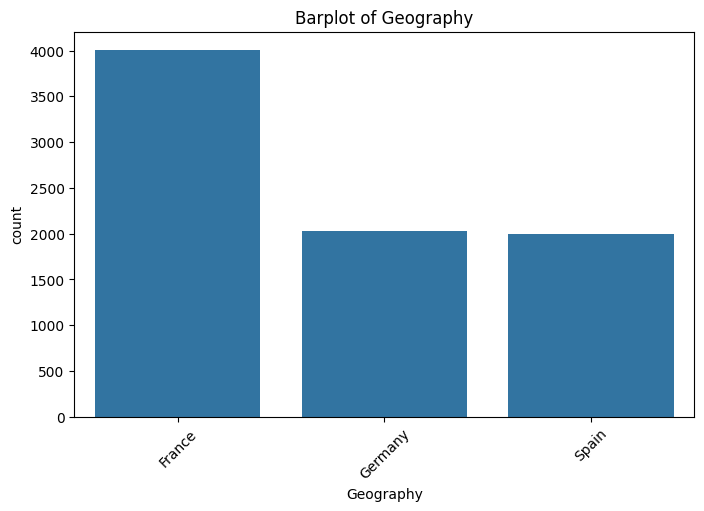

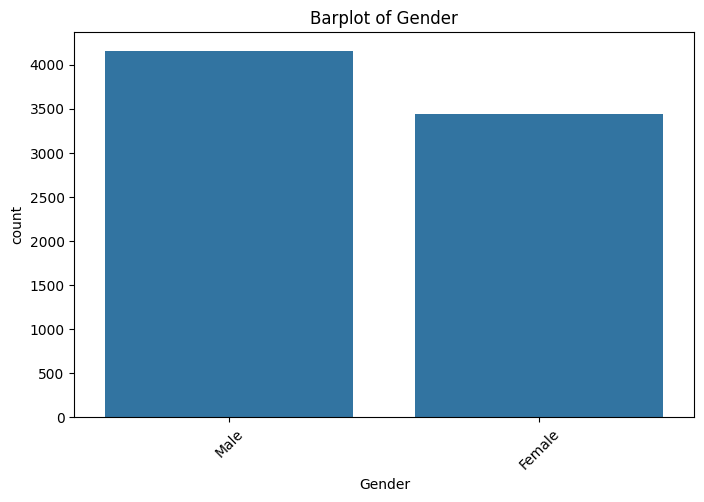

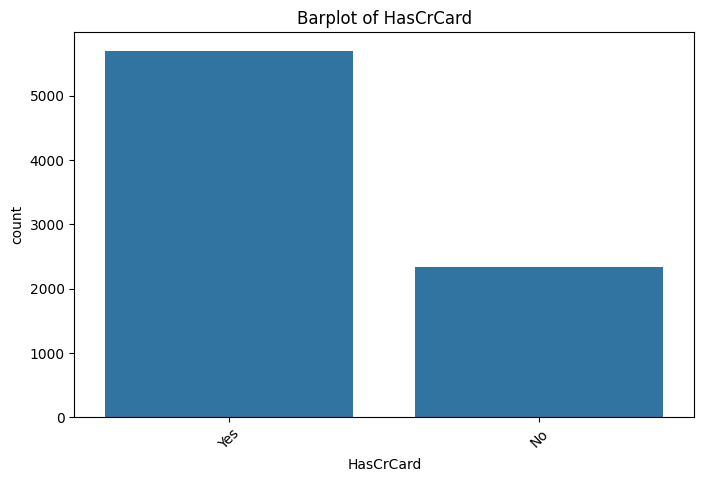

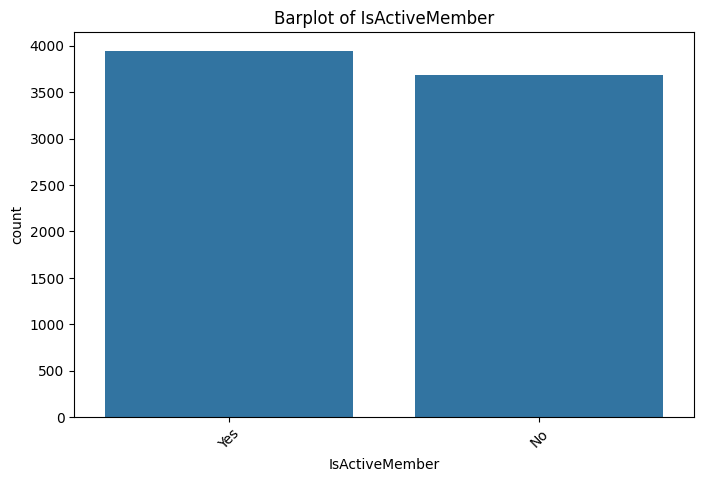

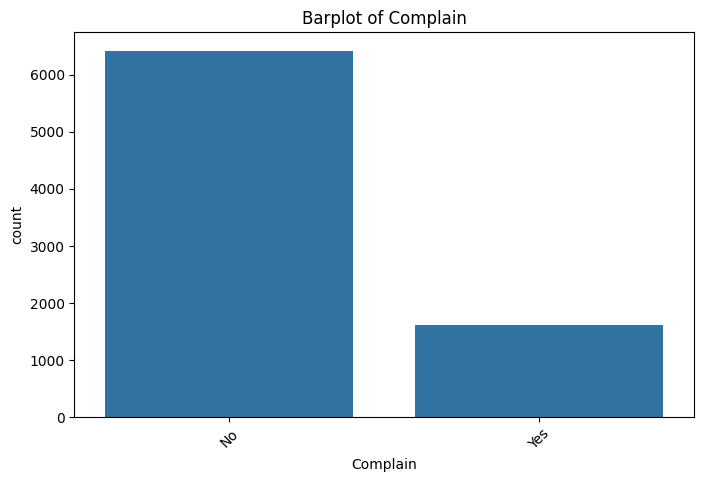

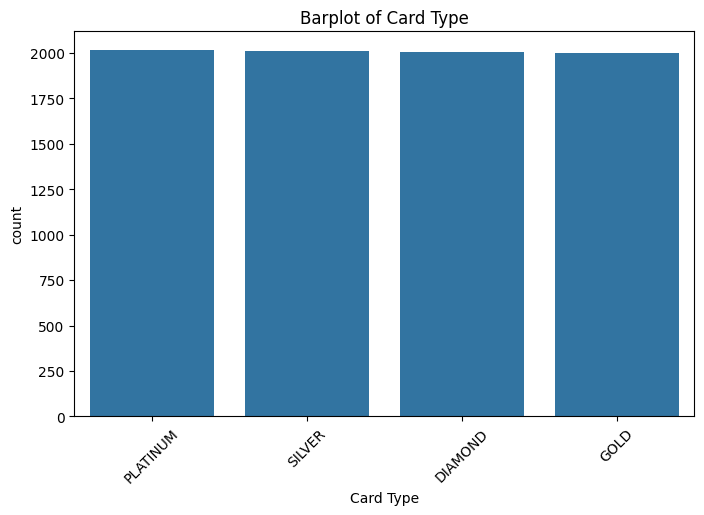

In [174]:
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train_data, x=col, order=train_data[col].value_counts().index)
    plt.title(f'Barplot of {col}')
    plt.xticks(rotation=45)
    plt.show()

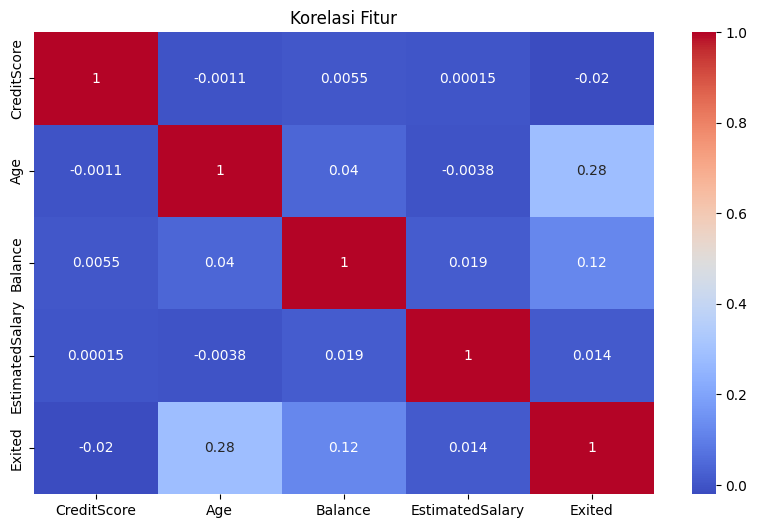

In [175]:


selected_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']

# Ambil subset data
df_selected = train_data[selected_features]  # Mengambil subset fitur dari DataFrame

# Plot heatmap korelasi
plt.figure(figsize=(10, 6))
sns.heatmap(df_selected.corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi Fitur")
plt.show()


Terlihat bahwa Age (Usia) memiliki korelasi positif yang relatif signifikan dengan variabel target Exited (sekitar 0.28). Ini menunjukkan bahwa semakin tua pelanggan, kemungkinan mereka churn lebih tinggi.
Balance juga menunjukkan korelasi yang lebih kecil (sekitar 0.12) dengan churn.

Preprocessing

In [176]:
print(train_data.info())
print(train_data.isna().sum().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8030 entries, 0 to 8029
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  8030 non-null   int64  
 1   Surname             8030 non-null   object 
 2   CreditScore         7603 non-null   float64
 3   Geography           8030 non-null   object 
 4   Gender              7607 non-null   object 
 5   Age                 7588 non-null   float64
 6   Tenure              8030 non-null   int64  
 7   Balance             8030 non-null   float64
 8   NumOfProducts       8030 non-null   int64  
 9   HasCrCard           8030 non-null   object 
 10  IsActiveMember      7628 non-null   object 
 11  EstimatedSalary     7664 non-null   float64
 12  Complain            8030 non-null   object 
 13  Satisfaction Score  8030 non-null   int64  
 14  Card Type           8030 non-null   object 
 15  Point Earned        8030 non-null   int64  
 16  Exited

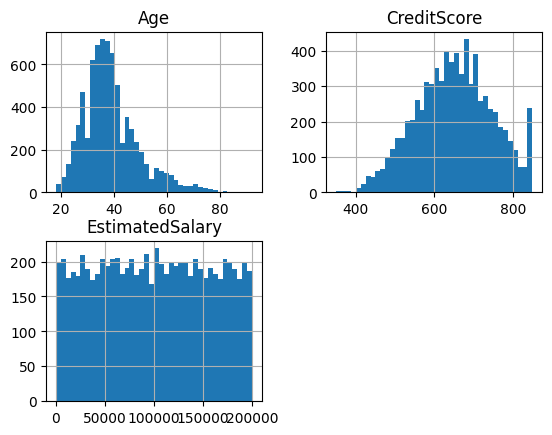

In [177]:
train_data[['Age', 'CreditScore', 'EstimatedSalary']].hist(bins=40);

<ipython-input-178-81903f7ba074>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(train_data[col].mean(), inplace=True)


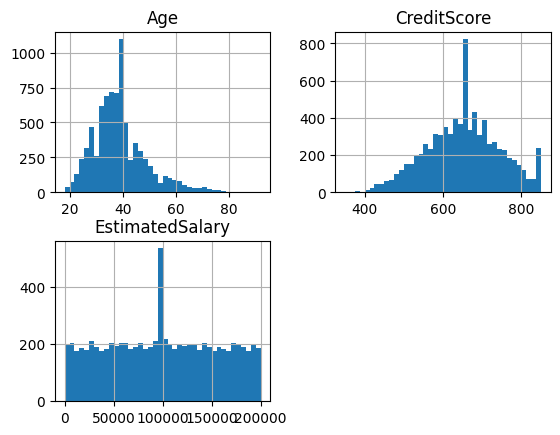

In [178]:
# Filling missing values
for col in ['Age', 'CreditScore', 'EstimatedSalary']:
    train_data[col].fillna(train_data[col].mean(), inplace=True)

train_data[['Age', 'CreditScore', 'EstimatedSalary']].hist(bins=40);

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [180]:
data = train_data.copy()

In [181]:
# Menghapus kolom yang tidak relevan
data.drop(['Surname'], axis=1, inplace=True)


In [182]:
# Encoding kolom kategorikal
categorical_cols = ['Gender', 'Geography', 'Card Type', 'HasCrCard', 'IsActiveMember', 'Complain']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [183]:
# Pisahkan fitur dan target
X = data.drop('Exited', axis=1)
y = data['Exited']

In [184]:
# Standardisasi fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [185]:
# Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Modelling dan Evaluasi

In [186]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [197]:
# Inisialisasi dan train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Random Forest adalah algoritma machine learning berbasis ensemble learning yang menggabungkan banyak decision tree untuk meningkatkan akurasi dan mengurangi overfitting. Algoritma ini bekerja dengan membuat banyak pohon keputusan (decision tree) secara acak, lalu menggabungkan hasilnya melalui voting (untuk klasifikasi) atau rata-rata (untuk regresi).

In [198]:
# Prediksi
y_pred = model.predict(X_test)

In [199]:
# Evaluasi model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[1296    2]
 [   0  308]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1298
           1       0.99      1.00      1.00       308

    accuracy                           1.00      1606
   macro avg       1.00      1.00      1.00      1606
weighted avg       1.00      1.00      1.00      1606


Accuracy: 0.9987546699875467


In [201]:
test_data_copy = test_data.copy()
test_data_copy.drop(['Surname'], axis=1, inplace=True)

# Encoding kolom kategorikal
test_data_encoded = pd.get_dummies(test_data_copy, columns=categorical_cols, drop_first=True)

# Pastikan jumlah kolom sama dengan training data
test_data_encoded = test_data_encoded.reindex(columns=X.columns, fill_value=0)

# Standardisasi
test_data_scaled = scaler.transform(test_data_encoded)

# Prediksi
test_predictions = model.predict(test_data_scaled)

# Membuat file submission
submission['Exited'] = test_predictions

submission.to_csv('submission.csv', index=False)
print("Prediksi telah disimpan ke 'submission.csv'")


Prediksi telah disimpan ke 'submission.csv'


In [202]:
submission.head()

,ID,Exited
0,2001,1
1,2002,0
2,2003,0
3,2004,0
4,2005,0
